## Import Libraries

In [1]:
!git clone https://github.com/ageron/handson-ml2.git
%cd handson-ml2/datasets/housing

fatal: destination path 'handson-ml2' already exists and is not an empty directory.
/content/handson-ml2/datasets/housing


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, ClusterMixin
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

## Load Data and Select Features

In [3]:
# Load the California housing dataset and select relevant features
housing = pd.read_csv('housing.csv')
clustering_housing = housing[['latitude', 'longitude', 'median_income']]

## Data Preprocessing

In [4]:
# Set up imputer and transformer
num_imputer = SimpleImputer(strategy='median')

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, base=np.e):
        self.base = base

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else None
        return self

    def transform(self, X):
        return np.log(X) / np.log(self.base)

    def inverse_transform(self, X):
        return self.base ** X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return ['transformed_' + feature for feature in input_features]

# Create log transformation pipeline
log_transformer = LogTransformer()
log_pipeline = make_pipeline(num_imputer, log_transformer, StandardScaler())

## Preprocess the data

In [5]:
# Preprocess the data
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer([
    ('log', log_pipeline, ['median_income']),
])
median_income = preprocessing.fit_transform(clustering_housing)
X = clustering_housing.copy()
X['median_income'] = median_income
print(X.shape)
print(preprocessing.get_feature_names_out())

(20640, 3)
['log__transformed_median_income']


## Define Custom KMeans Class

In [6]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import KMeans

class KMeansCluster(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)

    def fit(self, X, y=None):  # Added y=None
        self.kmeans.fit(X)
        return self

    def predict(self, X):
        return self.kmeans.predict(X)

## Hyperparameter Tuning with Grid Search

In [7]:
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.model_selection import GridSearchCV

# Set up parameter grid for KMeans clustering
param_grid = {
    'n_clusters': range(2, 11)  # Test k values from 2 to 10
}

# Create the KMeansCluster instance
kmeans = KMeansCluster()

# Define a custom scorer for silhouette score using KMeansCluster
def silhouette_scorer(estimator, X):
    labels = estimator.fit(X).predict(X)  # Fit and predict clusters
    return silhouette_score(X, labels)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, scoring=silhouette_scorer, cv=5)
grid_search.fit(X)  # No need for y parameter

# Get the best number of clusters
best_k = grid_search.best_params_['n_clusters']
print(f"Optimal number of clusters: {best_k}")

Optimal number of clusters: 2


## Fit KMeans with the Optimal k

In [8]:
# Fit KMeans with the optimal k
optimal_kmeans = KMeans(n_clusters=best_k, random_state=42)
optimal_kmeans.fit(X)

# Add cluster labels to the dataframe
X['Cluster'] = optimal_kmeans.labels_

## Visualize Clustering Results (Clusters of Housing Data)

Silhouette Score: 0.6662742221200735


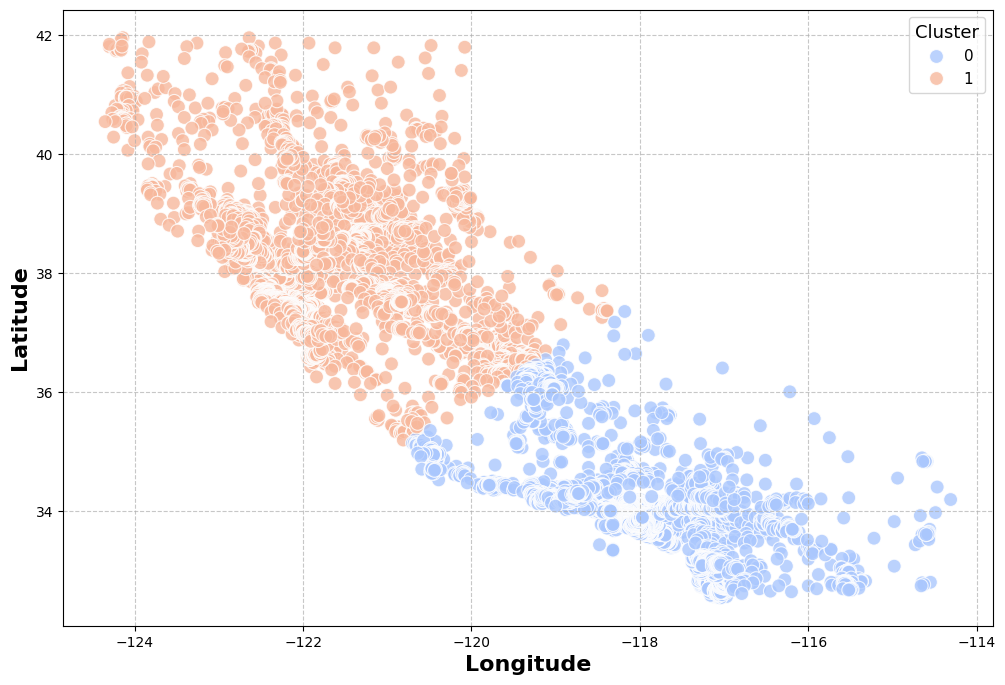

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(X, X['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Plotting clusters with a fancier palette
plt.figure(figsize=(12, 8))
sns.scatterplot(data=X, x='longitude', y='latitude', hue='Cluster', palette='coolwarm', alpha=0.8, edgecolor='w', s=100)
plt.title('', fontsize=18, weight='bold')
plt.xlabel('Longitude', fontsize=16, fontweight='bold')

plt.ylabel('Latitude', fontsize=16, fontweight='bold')
plt.legend(title='Cluster', title_fontsize='13', fontsize='11', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

## Analyze Cluster Centers

In [10]:
# Calculate cluster centers
centers = optimal_kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=['Longitude', 'Latitude', 'median_income'])

# Display cluster centers
print("Cluster Centers:\n", centers_df)

# Describe each cluster
cluster_analysis = X.groupby('Cluster').mean()
print("Cluster Analysis:\n", cluster_analysis)

Cluster Centers:
    Longitude    Latitude  median_income
0  33.939349 -118.006597       0.027841
1  37.955150 -121.715360      -0.038217
Cluster Analysis:
           latitude   longitude  median_income
Cluster                                      
0        33.939467 -118.006805       0.027822
1        37.955450 -121.715501      -0.038199
